In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sys import stdout

In [3]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Global PLSR

In [4]:
Total_X_data = pd.read_csv("X_data.csv")
Total_Y_data = pd.read_csv("PHN_aggregatd.csv")

Total_X_data.drop("Unnamed: 0", axis=1, inplace=True)
Total_Y_data.drop(["Unnamed: 0", "n_ap"], axis=1, inplace=True)

In [5]:
X_test = Total_X_data[:1068]
Y_test = Total_Y_data[:1068]

In [6]:
X_data = Total_X_data[1068:]
Y_data = Total_Y_data[1068:]

In [7]:
Total_Y_data

,first_ap_time,first_ap_amp,first_ap_width
0,6,58.881427,13.620909
1,6,46.183495,7.132705
2,7,34.122383,8.834176
3,7,41.796535,4.948380
4,6,57.832149,52.102653
...,...,...,...
5339,7,42.798500,8.396907
5340,7,52.140596,73.301461
5341,7,46.796831,8.157181
5342,7,53.797265,16.934689


## Scaling and splitting the X_data and Y_data

In [8]:
scaler_x = StandardScaler().fit(X_data)
scaler_y = StandardScaler().fit(Y_data)

X_data = scaler_x.transform(X_data)
Y_data = scaler_y.transform(Y_data)

In [9]:
X_data

array([[-1.14955359e+00, -1.10319564e+00,  1.30369352e-01, ...,
         1.28923763e+00, -1.44543133e+00,  1.72684630e+00],
       [ 5.89295984e-01, -9.44241236e-01, -1.62083958e+00, ...,
        -3.63682478e-01,  1.32434612e+00,  1.03999608e+00],
       [ 9.09610346e-01, -1.59867768e+00, -1.19346753e+00, ...,
        -1.12898833e+00, -5.87891388e-01, -5.07227755e-01],
       ...,
       [ 8.98993485e-01, -7.45896139e-04, -5.08781753e-01, ...,
         7.70895116e-01, -7.65495875e-01,  7.22655906e-01],
       [ 3.58513426e-01,  1.18161807e+00, -1.48958987e+00, ...,
         1.12434672e+00, -1.53420078e+00, -1.10967478e+00],
       [-6.76472643e-01, -9.23717539e-01,  1.45481438e+00, ...,
        -3.20371935e-01,  1.11780395e+00, -1.17143884e+00]])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_data,Y_data,test_size=0.2,random_state=357, shuffle=True)

## Finding optimal number of PLS components for global Model

In [11]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp, max_iter=1000)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
   
    
    return (y_cv, r2, mse)

In [12]:
# test with 15 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 15)
for n_comp in xticks:
    y_cv, r2, mse = optimise_pls_cv(X_data, Y_data, n_comp)
    r2s.append(r2)
    mses.append(mse)
   


In [13]:
# Plot the mses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

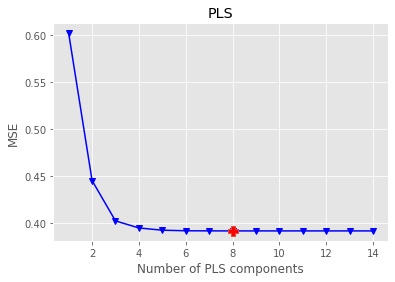

In [14]:
plot_metrics(mses, 'MSE', 'min')

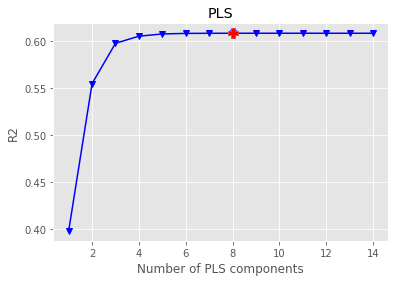

In [15]:
plot_metrics(r2s, 'R2', 'max')

## Predictions from global PLSR

In [16]:
global_pls = PLSRegression(n_components=8)

# Fit
global_pls.fit(X_data, Y_data)

# Cross-validation
y_cv = cross_val_predict(global_pls, X_data, Y_data, cv=10)

# Calculate scores
score = r2_score(Y_data, y_cv)
mse = mean_squared_error(Y_data, y_cv)

In [17]:
score

0.6083916936306141

In [18]:
mse

0.3916083063693859

In [19]:
##predictions

In [20]:
X_test = Total_X_data[:1068]
Y_test = Total_Y_data[:1068]

In [21]:
Test_X_data = scaler_x.transform(X_test)
Test_Y_data = scaler_y.transform(Y_test)

In [22]:
ypred2 = global_pls.predict(Test_X_data)
print(r2_score(Test_Y_data,ypred2))

0.613199622781279


In [23]:
Total_Y_data.columns

Index(['first_ap_time', 'first_ap_amp', 'first_ap_width'], dtype='object')

In [24]:
names = ['first_ap_time', 'first_ap_amp', 'first_ap_width']

In [25]:
results_df = pd.DataFrame()
ypred = global_pls.predict(Test_X_data)

extra_results_df = pd.DataFrame([r2_score(Test_Y_data[:,i],ypred[:,i]) for i in range(len(names))],index=names,columns=['r2_score'])
results_df = pd.concat([results_df,extra_results_df],axis=1)
results_df

,r2_score
first_ap_time,0.682207
first_ap_amp,0.913587
first_ap_width,0.243805


## Getting global X and Y scores

In [26]:
X_scores = global_pls.x_scores_
Y_scores = global_pls.y_scores_

In [27]:
X_scores.shape

(4276, 8)

In [28]:
Y_scores.shape

(4276, 8)

In [29]:
#initial plot

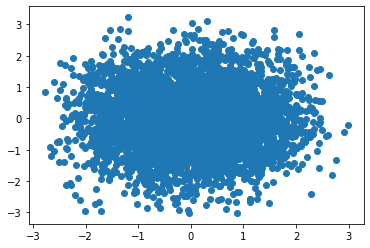

In [30]:
plt.scatter(X_scores[:,0], X_scores[:,1])

In [31]:
#### yaha  bata suru

## Clustering with X_scores

In [32]:
 from sklearn.cluster import KMeans

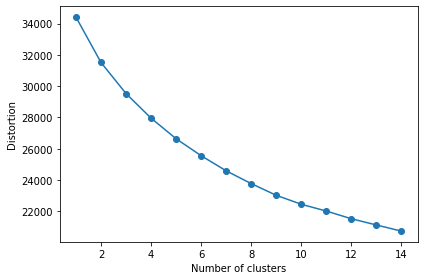

In [33]:
distortions = []
for i in range(1, 15):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    y_km = km.fit(X_scores)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()


In [34]:
from yellowbrick.cluster import KElbowVisualizer

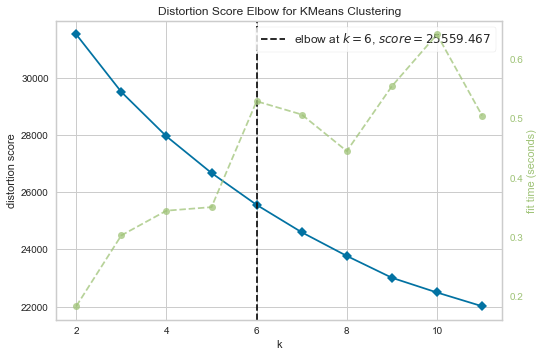

In [35]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_scores)        # Fit the data to the visualizer
visualizer.show()

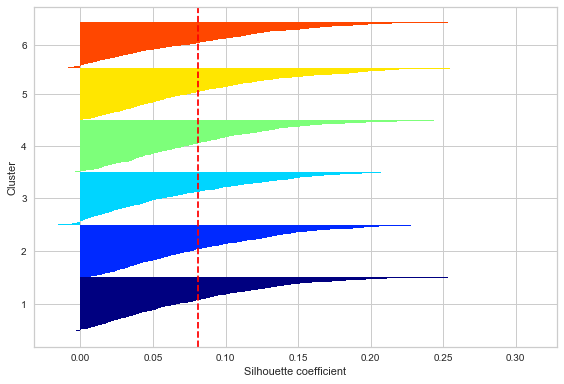

In [86]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

km = KMeans(n_clusters=6, 
            init='k-means++', 
            n_init=10, 
            max_iter=500,
            tol=1e-04,
            random_state=377)
y_km = km.fit_predict(X_scores)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_scores, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()


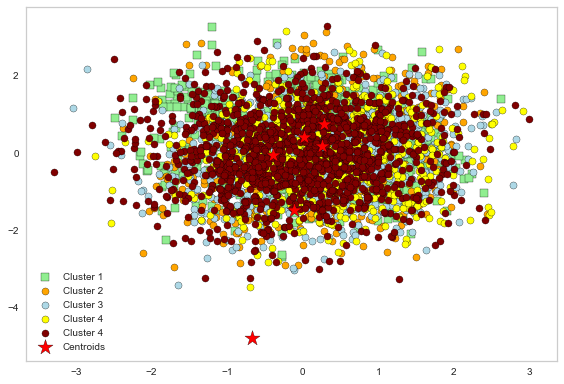

In [87]:
km = KMeans(n_clusters=6, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(Y_scores)


plt.scatter(X_scores[y_km == 0, 0],
            X_scores[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X_scores[y_km == 1, 0],
           X_scores[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X_scores[y_km == 2, 1],
           X_scores[y_km == 2, 2],
            s=50, c='lightblue',
            marker='o', edgecolor='black',
            label='Cluster 3')
plt.scatter(X_scores[y_km == 3, 2],
           X_scores[y_km == 3, 3],
            s=50, c='yellow',
            marker='o', edgecolor='black',
            label='Cluster 4')
plt.scatter(X_scores[y_km == 4, 3],
           X_scores[y_km == 4, 4],
            s=50, c='maroon',
            marker='o', edgecolor='black',
            label='Cluster 4')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

In [88]:
y_km

array([1, 1, 4, ..., 2, 0, 4])

In [89]:
X_score_df = pd.DataFrame(X_scores)

In [90]:
X_score_df

,0,1,2,3,4,5,6,7
0,-1.659269,0.137912,-0.503717,-1.191325,0.441221,1.695298,-0.659309,-1.075218
1,1.615011,1.288685,0.457449,-1.125403,-0.691048,0.679121,0.294277,-1.161827
2,-1.071765,0.360776,0.429568,0.000258,-0.230236,0.647133,-0.351384,0.084188
3,-0.585354,1.721321,0.559554,0.524083,0.423090,-2.655619,0.979959,-1.428075
4,-0.138216,0.362481,1.644938,-0.405064,0.077312,-0.768841,0.736434,0.365725
...,...,...,...,...,...,...,...,...
4271,-0.652277,0.018154,-0.932543,-2.547121,-1.212662,1.254672,0.643867,-0.834654
4272,-0.189907,-0.429355,0.150455,-2.154215,0.871342,0.013126,-1.330322,-0.822954
4273,0.302485,0.462996,-0.727287,0.161395,0.998660,-1.961543,-1.233265,-0.281278
4274,0.375454,-0.728032,-1.044260,1.084774,0.328865,0.220368,-0.504772,-2.294968


In [91]:
X_score_df['Cluster'] = y_km

In [92]:
X_cluster_df = X_score_df

In [93]:
X_cluster_df

,0,1,2,3,4,5,6,7,Cluster
0,-1.659269,0.137912,-0.503717,-1.191325,0.441221,1.695298,-0.659309,-1.075218,1
1,1.615011,1.288685,0.457449,-1.125403,-0.691048,0.679121,0.294277,-1.161827,1
2,-1.071765,0.360776,0.429568,0.000258,-0.230236,0.647133,-0.351384,0.084188,4
3,-0.585354,1.721321,0.559554,0.524083,0.423090,-2.655619,0.979959,-1.428075,4
4,-0.138216,0.362481,1.644938,-0.405064,0.077312,-0.768841,0.736434,0.365725,1
...,...,...,...,...,...,...,...,...,...
4271,-0.652277,0.018154,-0.932543,-2.547121,-1.212662,1.254672,0.643867,-0.834654,4
4272,-0.189907,-0.429355,0.150455,-2.154215,0.871342,0.013126,-1.330322,-0.822954,1
4273,0.302485,0.462996,-0.727287,0.161395,0.998660,-1.961543,-1.233265,-0.281278,2
4274,0.375454,-0.728032,-1.044260,1.084774,0.328865,0.220368,-0.504772,-2.294968,0


### Creating four dataframes having different cluster labels

In [94]:
X_cluster_1 = X_cluster_df.loc[X_cluster_df['Cluster'] == 1]

In [95]:
X_cluster_0 = X_cluster_df.loc[X_cluster_df['Cluster'] == 0]

In [96]:
X_cluster_2 = X_cluster_df.loc[X_cluster_df['Cluster'] == 2]

In [97]:
X_cluster_3 = X_cluster_df.loc[X_cluster_df['Cluster'] == 3]

In [98]:
X_cluster_4 = X_cluster_df.loc[X_cluster_df['Cluster'] == 4]

In [99]:
X_cluster_5 = X_cluster_df.loc[X_cluster_df['Cluster'] == 5]

In [101]:
X_cluster_5.shape

(117, 9)

In [102]:
X_cluster_1.head()

,0,1,2,3,4,5,6,7,Cluster
0,-1.659269,0.137912,-0.503717,-1.191325,0.441221,1.695298,-0.659309,-1.075218,1
1,1.615011,1.288685,0.457449,-1.125403,-0.691048,0.679121,0.294277,-1.161827,1
4,-0.138216,0.362481,1.644938,-0.405064,0.077312,-0.768841,0.736434,0.365725,1
7,2.057894,2.689192,-1.196074,1.290431,-0.271284,-1.456463,0.322068,-1.472571,1
12,0.529609,1.066582,2.601218,-2.423717,0.270539,0.492897,-0.106743,-1.225152,1


## Creating new X and Y dataset for local PLSR

## PLSR 0

In [103]:
X_cluster_0 = pd.DataFrame(X_cluster_0)
Y_data= pd.DataFrame(Y_data)
X_data = pd.DataFrame(X_data)

In [104]:
Y_data_0= Y_data[Y_data.index.isin(X_cluster_0.index)]
X_data_0= X_data[X_data.index.isin(X_cluster_0.index)]

In [105]:
X_data_0

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
15,-0.822187,-0.970038,-1.260854,-0.338483,-1.107790,-1.426974,0.334218,1.543145,1.103563,-1.013029,...,-1.512368,-1.246168,-0.317279,-0.242410,-0.940664,0.429490,0.632100,-0.625121,1.699065,-0.069487
16,-1.266177,-0.510560,-1.422105,1.665573,-0.242255,0.775754,-0.036350,-1.054651,-1.104698,1.445256,...,1.695150,1.645403,0.448512,-1.679717,-1.532781,-1.197771,1.006283,0.950091,1.052381,0.543406
18,0.422530,0.799792,-0.456750,1.187492,-1.531747,1.068254,-1.114982,-0.628467,-0.212765,-1.429021,...,-0.813753,-0.008088,-1.382215,-0.831209,-0.047356,-0.285084,0.705970,-0.559995,-1.284855,0.921184
21,-0.082655,-0.721002,-0.497186,-1.376300,0.597898,1.623806,-0.357302,1.518999,0.029405,-1.203896,...,-1.579760,-1.385004,-0.045132,-0.426204,1.096815,0.666716,-1.107921,-0.041434,0.400322,-1.544878
23,-0.963768,1.317342,0.781567,-0.218347,-0.317522,0.570319,0.628604,-1.524918,-0.576919,-1.687838,...,-0.447991,-0.710367,-0.253169,1.075571,-0.453630,0.417039,1.220406,-0.448044,1.574924,-0.338927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255,0.211747,1.091696,0.625692,-0.160382,-0.297024,0.815952,-0.445602,0.727223,-0.719059,1.020863,...,-0.695716,-0.878111,-0.139350,-1.473105,1.614395,0.940754,-0.279484,1.128559,-0.159279,-0.797038
4262,0.867046,0.720688,0.232891,-0.633052,0.890320,-1.075881,0.616365,1.567508,0.777496,-1.435757,...,0.435472,-1.071151,-0.978715,0.928112,-0.566600,0.734868,1.040939,0.173228,0.512104,1.602052
4263,-0.502953,1.662752,-1.214423,0.787117,-0.290609,0.874118,-1.566384,-1.080496,-0.643771,-1.480182,...,0.125894,-0.874997,0.151001,-1.550295,-0.690276,-1.305325,-1.614923,-0.079595,0.193165,-1.354286
4266,0.814557,1.686800,-0.781472,0.332157,1.001626,-0.507735,-1.314564,-1.068934,-1.071797,0.058031,...,-0.648907,0.234508,-0.154851,-1.237231,0.827114,-1.464199,0.231837,0.053900,0.742968,-1.132938


In [106]:
Y_data_0

,0,1,2
15,-0.923139,1.209039,-0.328857
16,-0.923139,-1.093817,-0.611610
18,0.364738,-1.666998,-0.470060
21,0.364738,-0.499788,0.144669
23,0.364738,0.577844,0.611808
...,...,...,...
4255,0.364738,-1.124997,-0.416009
4262,-0.923139,0.833979,2.151964
4263,1.652615,-0.971029,-0.461091
4266,1.652615,-1.736466,0.188114


## Following similar procedure for creating X and Y dataset for PLSR 1

In [107]:
X_cluster_1 = pd.DataFrame(X_cluster_1)

In [108]:
Y_data_1= Y_data[Y_data.index.isin(X_cluster_1.index)]
X_data_1= X_data[X_data.index.isin(X_cluster_1.index)]

## Following similar procedure for creating X and Y dataset for PLSR 2 ,3 and 4

In [109]:
X_cluster_2 = pd.DataFrame(X_cluster_2)

In [110]:
Y_data_2= Y_data[Y_data.index.isin(X_cluster_2.index)]
X_data_2= X_data[X_data.index.isin(X_cluster_2.index)]

In [111]:
X_cluster_3 = pd.DataFrame(X_cluster_3)

In [112]:
Y_data_3= Y_data[Y_data.index.isin(X_cluster_3.index)]
X_data_3= X_data[X_data.index.isin(X_cluster_3.index)]

In [113]:
X_cluster_4 = pd.DataFrame(X_cluster_4)

In [114]:
Y_data_4= Y_data[Y_data.index.isin(X_cluster_4.index)]
X_data_4= X_data[X_data.index.isin(X_cluster_4.index)]

In [115]:
X_cluster_5 = pd.DataFrame(X_cluster_5)

In [116]:
Y_data_5= Y_data[Y_data.index.isin(X_cluster_5.index)]
X_data_5= X_data[X_data.index.isin(X_cluster_5.index)]

### Training PLSR 0,1,2,3 ,4 and 5


In [117]:
## Training the whole

In [118]:
local_pls_0 = PLSRegression(n_components=8)

# Fit
local_pls_0.fit(X_data_0, Y_data_0)

# Cross-validation
y_cv = cross_val_predict(local_pls_0, X_data_0, Y_data_0, cv=10)

# Calculate scores
score = r2_score(Y_data_0, y_cv)
mse = mean_squared_error(Y_data_0, y_cv)

In [119]:
score

0.8041426010609847

In [120]:
mse

0.09607173310432178

## Training PLSR 1

In [121]:
## Training whole

In [122]:
local_pls_1 = PLSRegression(n_components=8)

# Fit
local_pls_1.fit(X_data_1, Y_data_1)

# Cross-validation
y_cv = cross_val_predict(local_pls_1, X_data_1, Y_data_1, cv=10)

# Calculate scores
score = r2_score(Y_data_1, y_cv)
mse = mean_squared_error(Y_data_1, y_cv)

In [123]:
score

0.7118539653806394

In [124]:
mse

0.44680933567238057

## Training PLSR 2

In [125]:
local_pls_2 = PLSRegression(n_components=8)

# Fit
local_pls_2.fit(X_data_2, Y_data_2)

# Cross-validation
y_cv = cross_val_predict(local_pls_2, X_data_2, Y_data_2, cv=10)

# Calculate scores
score = r2_score(Y_data_2, y_cv)
mse = mean_squared_error(Y_data_2, y_cv)

In [126]:
score

0.7529820352177374

In [127]:
mse

0.08632966692645976

## Training PLSR 3

In [128]:
local_pls_3 = PLSRegression(n_components=8)

# Fit
local_pls_3.fit(X_data_3, Y_data_3)

# Cross-validation
y_cv = cross_val_predict(local_pls_3, X_data_3, Y_data_3, cv=10)

# Calculate scores
score = r2_score(Y_data_3, y_cv)
mse = mean_squared_error(Y_data_3, y_cv)

In [129]:
score

0.645278477015449

In [130]:
mse

0.09403953319983838

### Training PLSR 4

In [131]:
local_pls_4 = PLSRegression(n_components=8)

# Fit
local_pls_4.fit(X_data_4, Y_data_4)

# Cross-validation
y_cv = cross_val_predict(local_pls_4, X_data_4, Y_data_4, cv=10)

# Calculate scores
score = r2_score(Y_data_4, y_cv)
mse = mean_squared_error(Y_data_4, y_cv)

In [132]:
score

0.7130791639060554

In [133]:
mse

0.07541392552014614

##### Training PLSR 5

In [134]:
X_data_5.shape

(117, 76)

In [135]:
local_pls_5 = PLSRegression(n_components=8)

# Fit
local_pls_5.fit(X_data_5, Y_data_5)

# Cross-validation
y_cv = cross_val_predict(local_pls_5, X_data_5, Y_data_5, cv=10)

# Calculate scores
score = r2_score(Y_data_5, y_cv)
mse = mean_squared_error(Y_data_5, y_cv)

In [136]:
score

0.2757184252800606

In [137]:
mse

0.8982370414912549

### HCPLSR Predictions

In [138]:
## scaling the test data from global scaler

In [139]:
X_test = Total_X_data[:1068]
Y_test = Total_Y_data[:1068]

In [140]:
Test_X_data = scaler_x.transform(X_test)

In [141]:
## predicted y_data

In [142]:
ypred_global = global_pls.predict(Test_X_data)

## Classification Algorithm with X

In [143]:
target = X_cluster_df.Cluster

In [144]:
X_cluster_df

,0,1,2,3,4,5,6,7,Cluster
0,-1.659269,0.137912,-0.503717,-1.191325,0.441221,1.695298,-0.659309,-1.075218,1
1,1.615011,1.288685,0.457449,-1.125403,-0.691048,0.679121,0.294277,-1.161827,1
2,-1.071765,0.360776,0.429568,0.000258,-0.230236,0.647133,-0.351384,0.084188,4
3,-0.585354,1.721321,0.559554,0.524083,0.423090,-2.655619,0.979959,-1.428075,4
4,-0.138216,0.362481,1.644938,-0.405064,0.077312,-0.768841,0.736434,0.365725,1
...,...,...,...,...,...,...,...,...,...
4271,-0.652277,0.018154,-0.932543,-2.547121,-1.212662,1.254672,0.643867,-0.834654,4
4272,-0.189907,-0.429355,0.150455,-2.154215,0.871342,0.013126,-1.330322,-0.822954,1
4273,0.302485,0.462996,-0.727287,0.161395,0.998660,-1.961543,-1.233265,-0.281278,2
4274,0.375454,-0.728032,-1.044260,1.084774,0.328865,0.220368,-0.504772,-2.294968,0


In [145]:
data =X_cluster_df.drop(["Cluster"], axis=1)

In [146]:
data

,0,1,2,3,4,5,6,7
0,-1.659269,0.137912,-0.503717,-1.191325,0.441221,1.695298,-0.659309,-1.075218
1,1.615011,1.288685,0.457449,-1.125403,-0.691048,0.679121,0.294277,-1.161827
2,-1.071765,0.360776,0.429568,0.000258,-0.230236,0.647133,-0.351384,0.084188
3,-0.585354,1.721321,0.559554,0.524083,0.423090,-2.655619,0.979959,-1.428075
4,-0.138216,0.362481,1.644938,-0.405064,0.077312,-0.768841,0.736434,0.365725
...,...,...,...,...,...,...,...,...
4271,-0.652277,0.018154,-0.932543,-2.547121,-1.212662,1.254672,0.643867,-0.834654
4272,-0.189907,-0.429355,0.150455,-2.154215,0.871342,0.013126,-1.330322,-0.822954
4273,0.302485,0.462996,-0.727287,0.161395,0.998660,-1.961543,-1.233265,-0.281278
4274,0.375454,-0.728032,-1.044260,1.084774,0.328865,0.220368,-0.504772,-2.294968


In [147]:
train_data, test_data, train_labels, test_labels = train_test_split(data, target, random_state=0, shuffle=True, test_size=0.3)

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree


# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),

			('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
                    

			('clf', svm.SVC(random_state=42))])

pipe_dt = Pipeline([

			('clf', tree.DecisionTreeClassifier(random_state=42))])

pipe_KNN = Pipeline([('scl', StandardScaler()),

			('clf', KNeighborsClassifier(n_neighbors=3))])

pipe_RF = Pipeline([

			('clf', RandomForestClassifier(random_state=42))])


# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt, pipe_KNN, pipe_RF]
			
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree', 3:'KNN', 4:'Random Forest'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(train_data, train_labels)

# Compare accuracies
for idx, val in enumerate(pipelines):
	print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(test_data, test_labels)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(test_data, test_labels) > best_acc:
		best_acc = val.score(test_data, test_labels)
		best_pipe = val
		best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

C:\Users\Ashesh\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression pipeline test accuracy: 0.380
Support Vector Machine pipeline test accuracy: 0.371
Decision Tree pipeline test accuracy: 0.330
KNN pipeline test accuracy: 0.297
Random Forest pipeline test accuracy: 0.412
Classifier with best accuracy: Random Forest


## Feature Selection and Hyperparameter Tuning RandomForest

In [149]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [150]:
rf = RandomForestClassifier()

In [151]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [152]:
grid_search.fit(train_data, train_labels)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 14.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [153]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}

In [ ]:
## fitting RF model with following features

In [154]:
rf_bp = RandomForestClassifier(bootstrap ='True',
 max_depth= 90,
 max_features= 3,
 min_samples_leaf = 3,
 min_samples_split = 10,
 n_estimators = 300)

In [155]:
rf_bp.fit(train_data, train_labels)

RandomForestClassifier(bootstrap='True', max_depth=90, max_features=3,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300)

In [156]:
forest_pred = rf_bp.predict(test_data)

In [157]:
from sklearn.metrics import accuracy_score

In [158]:
from sklearn.metrics import accuracy_score

In [159]:
accuracy_score(forest_pred, test_labels)

0.4224473889321902

## Training whole data

In [160]:
rf_whole = RandomForestClassifier(bootstrap ='True',
 max_depth= 110,
 max_features= 2,
 min_samples_leaf = 3,
 min_samples_split = 8,
 n_estimators = 200)

In [161]:
rf_whole.fit(data, target)

RandomForestClassifier(bootstrap='True', max_depth=110, max_features=2,
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)

### predicting class labels

In [162]:
global_x_weights = global_pls.x_weights_

In [163]:
Test_X_data

array([[-1.0511255 ,  1.44899485,  0.95959703, ...,  0.76370733,
         0.80519979,  0.45480522],
       [ 1.26341898,  0.74620904, -0.23286662, ..., -0.23116333,
        -0.83109032,  0.37200117],
       [ 0.80200898, -1.54219358, -0.98461002, ...,  0.61372948,
        -0.4345646 ,  0.04438796],
       ...,
       [ 0.84134831,  1.26298934,  0.54188917, ...,  1.01964696,
         1.40335163, -0.18085337],
       [-0.42963529, -0.1432256 , -0.02004518, ..., -1.70000438,
        -0.37569325,  1.00258156],
       [ 1.29396861,  0.57442155, -0.83468859, ..., -1.52161002,
        -0.54762489,  0.02775884]])

In [164]:
X_scores_proj = np.dot(Test_X_data,global_x_weights)

In [165]:
X_scores_proj

array([[ 1.13649056, -0.08392072, -0.37516839, ...,  2.00372333,
         1.08813401,  0.88597075],
       [-0.46188143,  1.1761236 ,  0.60908913, ..., -0.04370855,
         1.00129463,  0.87103049],
       [-1.55218651,  0.57734932, -0.50982084, ...,  1.19153802,
         1.28129748,  0.29753138],
       ...,
       [ 1.07520493, -0.86289948, -1.30945161, ..., -0.72631565,
        -0.08976007,  1.00710964],
       [-0.45230921, -0.84484572, -0.55117047, ...,  0.17561042,
         0.78684594, -0.48191823],
       [-0.36551798,  0.21759855, -0.45454234, ..., -0.93437511,
        -0.44939977, -1.22678277]])

In [171]:
pred_rf = rf_whole.predict(X_scores_proj)

In [172]:
pred_rf.shape

(1068,)

In [173]:
## Appending this to the projected_X_scores

In [174]:
projected_X_scores = pd.DataFrame(X_scores_proj)

In [175]:
projected_X_scores['Cluster'] = pred_rf

In [176]:
projected_X_scores


,0,1,2,3,4,5,6,7,Cluster
0,1.136491,-0.083921,-0.375168,-0.085730,0.895042,2.003723,1.088134,0.885971,4
1,-0.461881,1.176124,0.609089,-1.229547,1.324955,-0.043709,1.001295,0.871030,4
2,-1.552187,0.577349,-0.509821,-0.609637,-0.966493,1.191538,1.281297,0.297531,4
3,-0.138804,0.529017,0.392164,-0.073413,0.634821,-0.655733,-1.323056,-0.402522,2
4,0.533019,-1.853959,-0.233325,-0.613871,-1.437574,1.509737,0.721286,-0.190091,4
...,...,...,...,...,...,...,...,...,...
1063,0.335290,-0.880359,0.632480,1.110354,0.469298,-0.311407,-0.452391,-0.292255,3
1064,1.808698,1.154866,0.281126,0.506668,1.068688,0.062251,0.371456,-0.668896,2
1065,1.075205,-0.862899,-1.309452,0.569444,1.613558,-0.726316,-0.089760,1.007110,4
1066,-0.452309,-0.844846,-0.551170,1.517170,1.145125,0.175610,0.786846,-0.481918,3


## Extracting class label 0,1,2,3,4 and 5

In [177]:
X_scores_0 = projected_X_scores.loc[projected_X_scores['Cluster'] == 0].drop(["Cluster"],axis=1)
X_scores_1 = projected_X_scores.loc[projected_X_scores['Cluster'] == 1].drop(["Cluster"],axis=1)
X_scores_2 = projected_X_scores.loc[projected_X_scores['Cluster'] == 2].drop(["Cluster"],axis=1)
X_scores_3 = projected_X_scores.loc[projected_X_scores['Cluster'] == 3].drop(["Cluster"],axis=1)
X_scores_4 = projected_X_scores.loc[projected_X_scores['Cluster'] == 4].drop(["Cluster"],axis=1)
X_scores_5 = projected_X_scores.loc[projected_X_scores['Cluster'] == 5].drop(["Cluster"],axis=1)

In [178]:
Test_X_data = pd.DataFrame(Test_X_data)
Test_Y_data = pd.DataFrame(Test_Y_data)


In [202]:
Test_Y_data

,0,1,2
0,-0.923139,1.376673,-0.289839
1,-0.923139,-0.398494,-0.500270
2,0.364738,-2.084635,-0.445086
3,0.364738,-1.011790,-0.571113
4,-0.923139,1.229985,0.958228
...,...,...,...
1063,0.364738,0.440857,2.225985
1064,-2.211017,1.112777,-0.605792
1065,0.364738,1.428381,-0.422076
1066,1.652615,-0.840976,-0.335278


In [179]:
Test_X_data_0= Test_X_data[Test_X_data.index.isin(X_scores_0.index)]
Test_X_data_1= Test_X_data[Test_X_data.index.isin(X_scores_1.index)]
Test_X_data_2= Test_X_data[Test_X_data.index.isin(X_scores_2.index)]
Test_X_data_3= Test_X_data[Test_X_data.index.isin(X_scores_3.index)]
Test_X_data_4= Test_X_data[Test_X_data.index.isin(X_scores_4.index)]
Test_X_data_5= Test_X_data[Test_X_data.index.isin(X_scores_5.index)]

In [180]:
Test_Y_data_0 = Test_Y_data[Test_Y_data.index.isin(X_scores_0.index)]
Test_Y_data_1 = Test_Y_data[Test_Y_data.index.isin(X_scores_1.index)]
Test_Y_data_2 = Test_Y_data[Test_Y_data.index.isin(X_scores_2.index)]
Test_Y_data_3 = Test_Y_data[Test_Y_data.index.isin(X_scores_3.index)]
Test_Y_data_4 = Test_Y_data[Test_Y_data.index.isin(X_scores_4.index)]
Test_Y_data_5 = Test_Y_data[Test_Y_data.index.isin(X_scores_5.index)]

In [181]:
## Predictions

In [182]:
pred_0 = local_pls_0.predict(Test_X_data_0)
pred_1 = local_pls_1.predict(Test_X_data_1)
pred_2 = local_pls_2.predict(Test_X_data_2)
pred_3 = local_pls_3.predict(Test_X_data_3)
pred_4 = local_pls_4.predict(Test_X_data_4)
pred_5 = local_pls_5.predict(Test_X_data_5)

In [183]:
all_pred = np.concatenate([pred_0, pred_1, pred_2, pred_3,pred_4, pred_5])

In [184]:
all_pred.shape


(1068, 3)

In [185]:
## Appending Truth values Y_test 

In [186]:
Y_test_sequential = pd.concat([Test_Y_data_0, Test_Y_data_1, Test_Y_data_2, Test_Y_data_3, Test_Y_data_4, Test_Y_data_5])

In [201]:
Test_X_data_0

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
7,-1.606426,-1.491618,1.480516,-0.430442,-1.244627,-0.968661,-1.120541,-0.898947,-1.675913,0.846018,...,-1.139774,-1.203663,-0.534347,-1.719829,-1.108717,0.876623,0.959507,0.908089,-1.201873,0.943896
8,-1.329650,0.558393,0.663825,1.440943,0.868027,-1.111181,0.508826,-1.032275,1.479526,0.372341,...,1.625018,-0.020165,-0.098965,-1.658504,-1.216165,-0.904081,0.769799,-1.400929,0.455939,0.750394
9,0.250249,-1.717745,0.353663,-0.903930,1.546557,-1.635149,0.024558,1.614358,1.079114,0.361289,...,0.840684,-1.631503,1.128056,0.231640,0.700406,-0.876542,-1.034083,-1.663613,0.309919,0.963658
27,1.081177,1.210450,-0.237808,-0.479665,0.192646,0.354436,0.950178,-1.384853,1.027385,1.052158,...,-0.772164,-1.002918,-1.593270,-0.079176,-0.257430,-1.105124,-0.964759,-0.171770,1.252617,-0.209230
46,1.740240,0.780345,-1.194966,1.663695,1.602967,-0.882586,1.164194,1.469736,0.846895,-0.567062,...,-1.089061,-1.454173,-1.503145,-0.258006,0.290011,-1.567941,-1.719457,-1.477427,0.866022,-0.216464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,0.993485,-0.202911,0.731393,1.672671,0.987788,-1.343158,1.086596,-0.719255,1.450488,0.307677,...,1.371760,0.668079,1.576489,0.110402,-0.376606,0.583982,-1.219208,-1.409521,1.388056,0.353996
1052,1.423922,-1.395493,-1.533240,0.849275,1.433480,0.065857,-0.705120,-1.603429,-1.232842,1.035603,...,-1.204330,-0.338225,-1.302905,-1.482191,0.141592,-0.375617,-1.473707,-1.090946,-1.177734,-1.468359
1057,1.653853,-1.079941,-0.548954,0.121604,-0.749101,-0.398739,-0.721193,-1.245336,1.282776,0.041207,...,1.666651,1.185134,0.694253,-1.015475,1.711964,0.906826,1.059512,0.862072,-0.684968,-1.301295
1058,-1.285350,0.162457,0.254583,-0.990191,-0.299518,1.353038,1.353500,0.389497,1.643671,-1.507366,...,1.198096,-1.453167,0.492117,-1.704275,-0.628407,1.057761,0.035675,1.691702,0.363445,-1.373053


In [187]:
Y_test_sequential

,0,1,2
7,-2.211017,-0.965232,0.125401
8,-0.923139,1.614527,-0.468019
9,-0.923139,0.998349,-0.543399
27,-0.923139,0.706541,-0.400366
46,-0.923139,0.852231,-0.557501
...,...,...,...
1067,0.364738,-0.214965,-0.393715
176,0.364738,0.160373,2.982766
242,1.652615,-0.775068,-0.062805
327,0.364738,-0.765666,-0.225660


In [188]:
print(r2_score(Y_test_sequential,all_pred))

0.4475225359115819


In [189]:
Y_test_sequential = Y_test_sequential.to_numpy()

In [190]:
extra_results_df = pd.DataFrame([r2_score(Y_test_sequential[:,i],all_pred[:,i]) for i in range(len(names))],index=names,columns=['r2_score'])
results_df = pd.concat([results_df,extra_results_df],axis=1)
results_df

,r2_score,r2_score
first_ap_time,0.682207,0.600645
first_ap_amp,0.913587,0.901715
first_ap_width,0.243805,-0.159792


## Plots

In [191]:
global_reg = pd.DataFrame(global_pls.coef_)
local_0_reg = pd.DataFrame(local_pls_0.coef_)
local_1_reg = pd.DataFrame(local_pls_1.coef_)
local_2_reg = pd.DataFrame(local_pls_2.coef_)
local_3_reg = pd.DataFrame(local_pls_3.coef_)
local_4_reg = pd.DataFrame(local_pls_4.coef_)
local_5_reg = pd.DataFrame(local_pls_5.coef_)

In [192]:
g = global_pls.coef_
p0= local_pls_0.coef_
p1= local_pls_1.coef_
p2=local_pls_2.coef_
p3=local_pls_3.coef_
p4=local_pls_4.coef_
p5=local_pls_5.coef_

In [193]:
global_reg

,0,1,2
0,0.033862,-0.126467,0.003602
1,-0.004444,0.001810,0.006863
2,-0.137271,0.118695,0.169205
3,-0.004934,-0.007385,-0.104640
4,0.071261,-0.017679,-0.021510
...,...,...,...
71,0.015105,0.003776,-0.013317
72,0.001290,-0.006121,0.028293
73,0.010857,0.001012,-0.007523
74,-0.017514,-0.006458,-0.002826


In [211]:
coeffs= np.array([p0,p1,p2,p3,p4,p5])

In [212]:
coeffs.shape

(6, 76, 3)

In [213]:
headers = ['V_myo(um3)', 'V_SR(um3)', 'V_myo_uL(uL)', 'V_SR_uL(uL)',
       'i_NaK_max(uA)', 'K_m_K(mM)', 'K_m_Na(mM)', 'K_o(millimolar)',
        'Na_o(millimolar)',
           'Ca_TRPN_Max(mM)', 'g_Na(microS)', 'g_t(microS)',
       'a_endo', 'b_endo', 'g_ss(microS)', 'g_K1(microS)', 'g_f(microS)',
       'f_Na', 'g_B_Na(microS)', 'g_B_Ca(microS)', 'g_B_K(microS)',
       'E_Ca(millivolt)', 'Ca_o(millimolar)', 'g_D(um3_per_ms)',
       'J_R(um3_per_ms)', 'J_L(um3_per_ms)', 'N', 'K_mNa(mM)', 'K_mCa(mM)',
       'eta', 'k_sat', 'g_NCX(mM_per_ms)', 'g_SERCA(mM_per_ms)', 'K_SERCA(mM)',
       'g_pCa(mM_per_ms)', 'K_mpCa(mM)', 'g_CaB(mM_per_mV_ms)',
       'g_SRl(per_ms)', 'k_CMDN(mM)', 'B_CMDN(mM)', 'k_on(per_mM_per_ms)',
       'k_Ref_off(per_ms)', 'gamma_trpn', 'alpha_0(per_ms)',
       'alpha_r1(per_ms)', 'alpha_r2(per_ms)', 'n_Rel', 'K_z', 'n_Hill',
       'Ca_50ref(mM)', 'z_p', 'beta_1', 'beta_0', 'T_ref(N_per_mm2)',
       'a in component Cross_Bridges', 'A_1', 'A_2', 'A_3', 'alpha_1(per_ms)',
       'alpha_2(per_ms)', 'alpha_3(per_ms)', 'V_L(mV)', 'del_VL(mV)', 'phi_L',
       't_L(ms)', 'tau_L(ms)', 'tau_R(ms)', 'phi_R', 'theta_R', 'K_RyR(mM)',
       'K_L(mM)', 'a', 'b', 'c', 'd', 'tau_s_ss']

In [214]:
ag_names = ['Time to AP','Amplitude of AP','Width of AP']

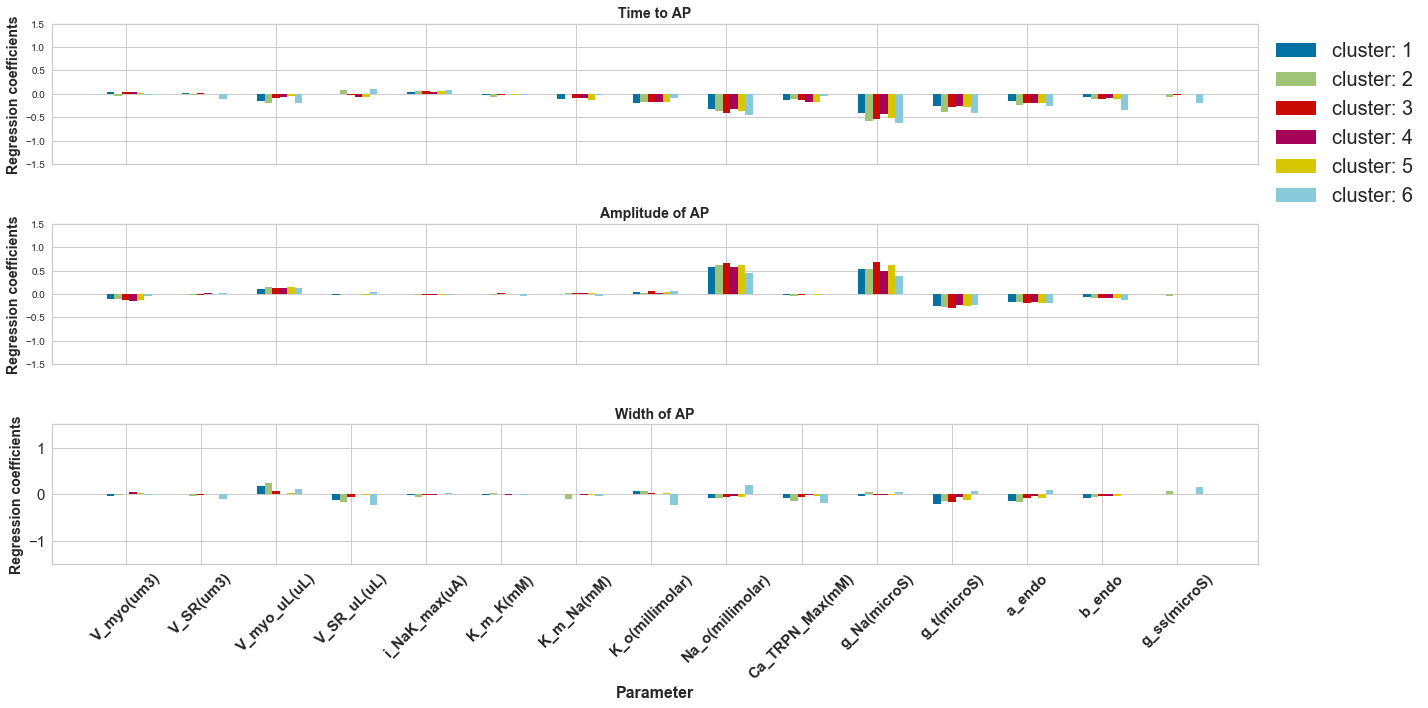

In [276]:

plt.figure(figsize=(20,10))
for n,agt in enumerate(ag_names):
  plt.subplot(3,1,n+1)
  plt.title(ag_names[n],fontweight='bold',fontsize=14)
  width=0.1

  x = np.array([i for i in range(0,15)])

  plt.bar(x-0.2,coeffs[0,:15,n].T,width=width,label='cluster: 1')
  plt.bar(x-0.1,coeffs[1,:15,n].T,width=width,label='cluster: 2')
  plt.bar(x    ,coeffs[2,:15,n].T,width=width,label='cluster: 3')
  plt.bar(x+0.1,coeffs[3,:15,n].T,width=width,label='cluster: 4')
  plt.bar(x+0.2,coeffs[4,:15,n].T,width=width,label='cluster: 5')
  plt.bar(x+0.3,coeffs[5,:15,n].T,width=width,label='cluster: 6')
  
  
  if n == 0:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coefficients',fontweight='bold',fontsize=14)
    plt.tick_params(axis='x',labelbottom=False)
    plt.legend(bbox_to_anchor=(1, 1),prop={'size': 20})
    
  elif n == 1:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coefficients',fontweight='bold',fontsize=14)
    plt.tick_params(axis='x',labelbottom=False)
    
    
  else:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coefficients',fontweight='bold',fontsize=14)
    #plt.xticks(x,headers[:8],fontweight='bold',fontsize=16)
    ax=plt.gca()
    ax.set_xticks(x)
    
    #ax.set_xtickslabels(headers[:14])
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(headers, weight='bold', rotation=45)
    plt.xlabel('Parameter',fontweight='bold',fontsize=16)
    
    plt.tight_layout()

## selecting important ones

In [277]:
headers = ['V_myo(um3)', 'V_SR(um3)', 'V_myo_uL(uL)', 'V_SR_uL(uL)',
       'i_NaK_max(uA)', 'K_m_K(mM)', 'K_m_Na(mM)', 'K_o(millimolar)',
        'Na_o(millimolar)',
           'Ca_TRPN_Max(mM)', 'g_Na(microS)', 'g_t(microS)',
       'a_endo', 'b_endo', 'g_ss(microS)', 'g_K1(microS)', 'g_f(microS)',
       'f_Na', 'g_B_Na(microS)', 'g_B_Ca(microS)', 'g_B_K(microS)',
       'E_Ca(millivolt)', 'Ca_o(millimolar)', 'g_D(um3_per_ms)',
       'J_R(um3_per_ms)', 'J_L(um3_per_ms)', 'N', 'K_mNa(mM)', 'K_mCa(mM)',
       'eta', 'k_sat', 'g_NCX(mM_per_ms)', 'g_SERCA(mM_per_ms)', 'K_SERCA(mM)',
       'g_pCa(mM_per_ms)', 'K_mpCa(mM)', 'g_CaB(mM_per_mV_ms)',
       'g_SRl(per_ms)', 'k_CMDN(mM)', 'B_CMDN(mM)', 'k_on(per_mM_per_ms)',
       'k_Ref_off(per_ms)', 'gamma_trpn', 'alpha_0(per_ms)',
       'alpha_r1(per_ms)', 'alpha_r2(per_ms)', 'n_Rel', 'K_z', 'n_Hill',
       'Ca_50ref(mM)', 'z_p', 'beta_1', 'beta_0', 'T_ref(N_per_mm2)',
       'a in component Cross_Bridges', 'A_1', 'A_2', 'A_3', 'alpha_1(per_ms)',
       'alpha_2(per_ms)', 'alpha_3(per_ms)', 'V_L(mV)', 'del_VL(mV)', 'phi_L',
       't_L(ms)', 'tau_L(ms)', 'tau_R(ms)', 'phi_R', 'theta_R', 'K_RyR(mM)',
       'K_L(mM)', 'a', 'b', 'c', 'd', 'tau_s_ss']

In [312]:
sign_indexes = []
sign_headers = []
for agt in range(3):
  sign_ind = []
  sign_head = []
  for i in range(1,coeffs.shape[1]):

    if np.any(abs(np.squeeze(coeffs[:,i,agt])) > np.max(abs(coeffs[:,:76,agt]))*0.5):  # Significant if 5% of maximum value
      sign_ind.append(i)
      sign_head.append(headers[i])
  sign_indexes.append(sign_ind)
  sign_headers.append(sign_head)
  
sign_indexes = np.array(sign_indexes)

In [313]:
sign_indexes[2]

[2, 3, 7, 8, 9, 11, 23, 25, 30, 41, 53, 59, 65, 69]

In [315]:
sign_headers[2]

['V_myo_uL(uL)',
 'V_SR_uL(uL)',
 'K_o(millimolar)',
 'Na_o(millimolar)',
 'Ca_TRPN_Max(mM)',
 'g_t(microS)',
 'g_D(um3_per_ms)',
 'J_L(um3_per_ms)',
 'k_sat',
 'k_Ref_off(per_ms)',
 'T_ref(N_per_mm2)',
 'alpha_2(per_ms)',
 'tau_L(ms)',
 'K_RyR(mM)']

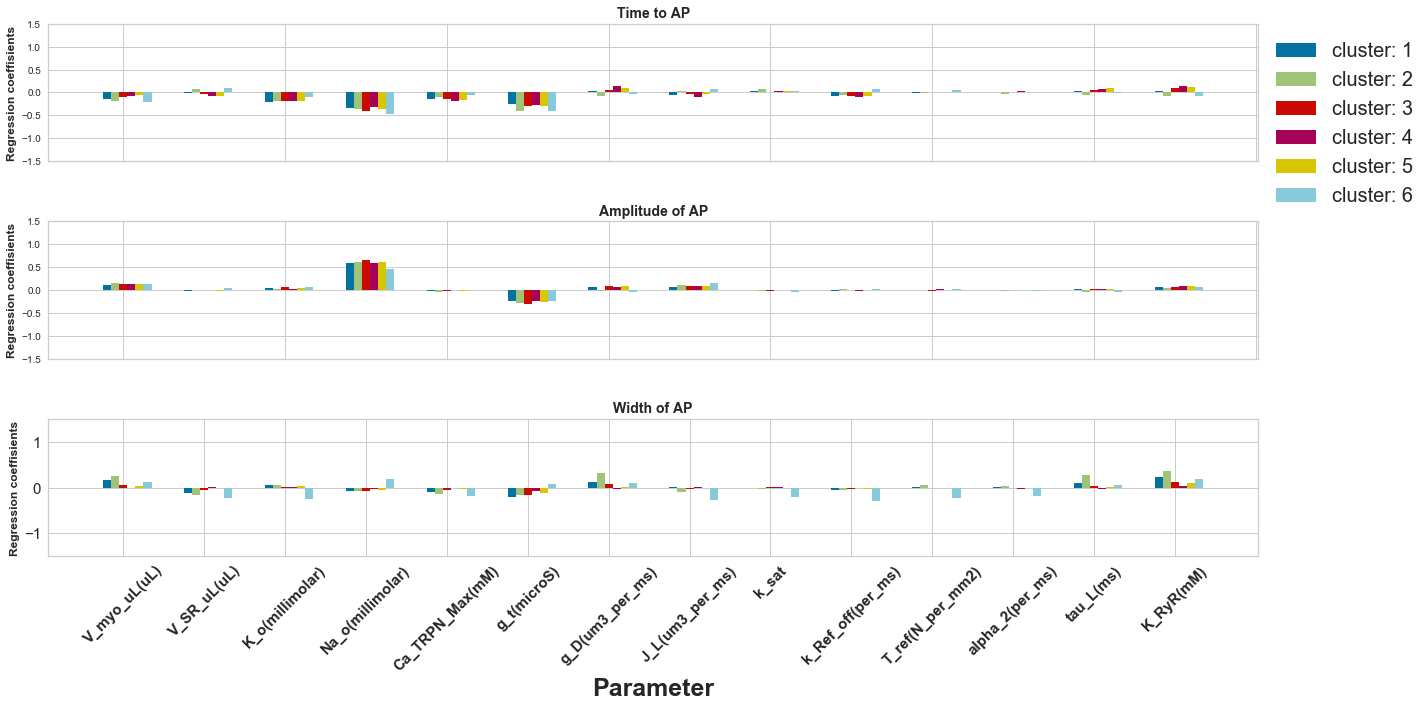

In [321]:
new_sign_indexes = np.array(sign_indexes[2])
new_sign_headers = np.array(sign_headers[2])
plt.figure(figsize=(20,10))
for n,agt in enumerate(ag_names):
  plt.subplot(3,1,n+1)
  plt.title(ag_names[n],fontweight='bold',fontsize=14)
  width=0.1


  x = np.array([i for i in range(0,14)])
  plt.bar(x-0.2,coeffs[0,new_sign_indexes,n].T,width=width,label='cluster: 1');
  plt.bar(x-0.1,coeffs[1,new_sign_indexes,n].T,width=width,label='cluster: 2');
  plt.bar(x    ,coeffs[2,new_sign_indexes,n].T,width=width,label='cluster: 3');
  plt.bar(x+0.1,coeffs[3,new_sign_indexes,n].T,width=width,label='cluster: 4');
  plt.bar(x+0.2,coeffs[4,new_sign_indexes,n].T,width=width,label='cluster: 5');
  plt.bar(x+0.3,coeffs[5,new_sign_indexes,n].T,width=width,label='cluster: 6');

  if n == 0:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.tick_params(axis='x',labelbottom=False)
    plt.legend(bbox_to_anchor=(1, 1),prop={'size': 20})
    
  elif n == 1:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.tick_params(axis='x',labelbottom=False)
    
    
  else:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    #plt.xticks(x,new_sign_headers,fontweight='bold',fontsize=16,rotation=90);
    ax=plt.gca()
    ax.set_xticks(x)
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(new_sign_headers, weight='bold', rotation=45)
    plt.xlabel('Parameter',fontweight='bold',fontsize=100)

    plt.xlabel('Parameter',fontweight='bold',fontsize=25)
    
    
    


plt.tight_layout()